In [2]:
import numpy as np
import time
from glob import glob
from natsort import natsorted
from skimage.measure import label
from skimage.segmentation import relabel_sequential
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from metrics import evaluate 
from utils import *
import cv2, os
import skimage.io as io

In [21]:
meds = ["graphcl", "wsh", "cncpt"]
len_test = 20

In [43]:

graphcl_path = natsorted (glob ('/home/tuan/GraphCL3D/deploy/64_cremi3D/test/*.tif')) [:len_test]
unet_wsh_path = natsorted (glob ('/home/tuan/CNN3D/deploy/64_cremi3D/wsh*.tif')) [:len_test]
unet_thr_path = natsorted (glob ('/home/tuan/CNN3D/deploy/64_cremi3D/thres*.tif')) [:len_test]
unet_cncpt_path = natsorted (glob ('/home/tuan/CNN3D/deploy/64_cremi3D/labeled*.tif')) [:len_test]
gt_path = natsorted (glob ('/home/tuan/Data/Cremi/3D_64/test/B/*.tif'))
em_path = natsorted (glob ('/home/tuan/Data/Cremi/3D_64/test/A/*.tif'))


In [56]:
def watershed_full (image, min_dist=12):
    image = image [::-1]
    distance = ndi.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, min_distance=min_dist, labels=image, exclude_border=False)
    markers = ndi.label(local_maxi)[0]
    watershed_lbl = watershed(-distance, markers, mask=image).astype (np.int32)
    return watershed_lbl [::-1]

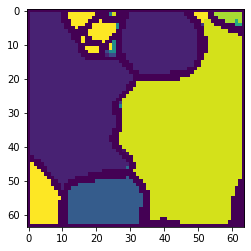

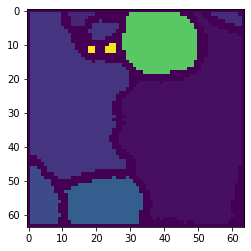

In [49]:
plt.imshow (graphcl [10][10])
plt.show ()

plt.imshow (gt [10][10])
plt.show ()

In [57]:

graphcl = [io.imread (pth) for pth in graphcl_path]
unet_wsh = [io.imread (pth) for pth in unet_wsh_path]
unet_thr = [io.imread (pth) for pth in unet_thr_path]
unet_cncpt = [io.imread (pth) for pth in unet_cncpt_path]
em =  [io.imread (pth) for pth in em_path]
gt = [io.imread (pth) for pth in gt_path]

In [58]:
unet_wsh = [watershed_full (img, 15) for img in unet_thr]

In [52]:
gt_median_sizes = [np.median(np.unique (img, return_counts=True)[1]) for img in gt]
max_ids = np.max ([len (np.unique (img)) for img in gt])
print (gt_median_sizes)
print ("max id: ", max_ids)
print ("Mean ", np.min (gt_median_sizes))

[2.0, 9.0, 3.0, 3.0, 25.0, 2.0, 3.0, 3.0, 349.0, 6.0, 4.0, 2.0, 4.0, 4.0, 52.0, 3.5, 3.0, 4.0, 7.0, 2.0]
max id:  95
Mean  2.0


In [61]:
#Post-processing GraphCL
metrics = ["bestDice", "rand_i", "voi_split", "voi_merge", "adapted_rand", "AJI"]
minsize = 200
scores = np.zeros (len (metrics))

post_processed = []
post_proc_time = 0

for i in range (len_test):
    curtime = time.time ()
    pred_lbl = label (graphcl [i])
    gt_lbl = gt [i]
    pred_lbl = relabel_sequential (clean (pred_lbl, minsize)) [0]
    post_processed += [pred_lbl]
    post_proc_time += time.time () - curtime
    
#     size = gt_lbl.shape
#     pred_lbl = cv2.resize (pred_lbl.astype (np.int32), size, interpolation=cv2.INTER_NEAREST)
    
    scores += np.array (evaluate (pred_lbl, gt_lbl))

avg_post_proc_time = post_proc_time / len_test
scores /= len_test
    
for met, score in zip (metrics, scores):
    print (met, ":\t", score)
print ("Post processing time: ", avg_post_proc_time)

bestDice :	 0.5700461719175968
rand_i :	 0.7539123839650823
voi_split :	 0.661559692161396
voi_merge :	 0.42970915883805116
adapted_rand :	 0.21455569414883566
AJI :	 0.36303861925503395
Post processing time:  0.012852883338928223


In [39]:
graphcl = post_processed

In [60]:
metrics = ["bestDice", "rand_i", "voi_split", "voi_merge", "adapted_rand", "AJI"]
tmp = []
meds = ["graphcl", "wsh", "cncpt"]
res = [graphcl, unet_wsh, unet_cncpt]

for med, met, lbl_lists in zip (meds, metrics, res):
    if med == 'graphcl':
        continue
    scores = np.zeros (len (metrics))
    for i in range (len_test):
        gt_lbl = gt [i]
        pred_lbl = lbl_lists [i]
        scores += np.array (evaluate (pred_lbl, gt_lbl))
        lbl_lists [i] = pred_lbl
    tmp += [lbl_lists]
    scores /= len_test
    print (med)
    for met, score in zip (metrics, scores):
        print (met, ":\t", score)
    print ('-' * 60)
unet_wsh, unet_cncpt = tmp

wsh
bestDice :	 0.6943372845725806
rand_i :	 0.6017330904131205
voi_split :	 0.4456130140610612
voi_merge :	 1.1653846157973584
adapted_rand :	 0.3824698757960714
AJI :	 0.1129982296506323
------------------------------------------------------------
cncpt
bestDice :	 0.4287935046037159
rand_i :	 0.14151147565814615
voi_split :	 0.13508370645704199
voi_merge :	 2.9905170637257386
adapted_rand :	 0.7213617298494024
AJI :	 0.025515954296994686
------------------------------------------------------------


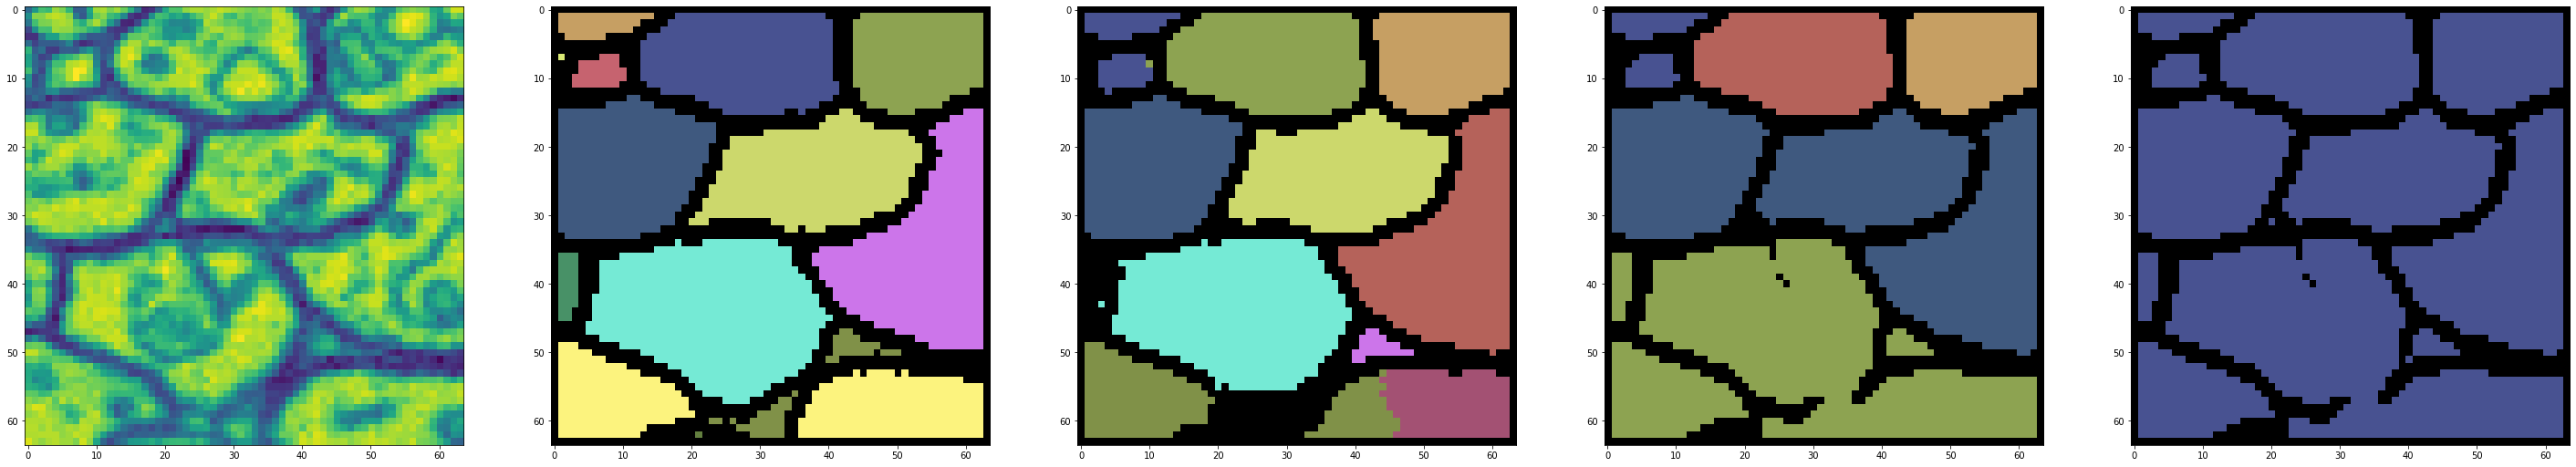

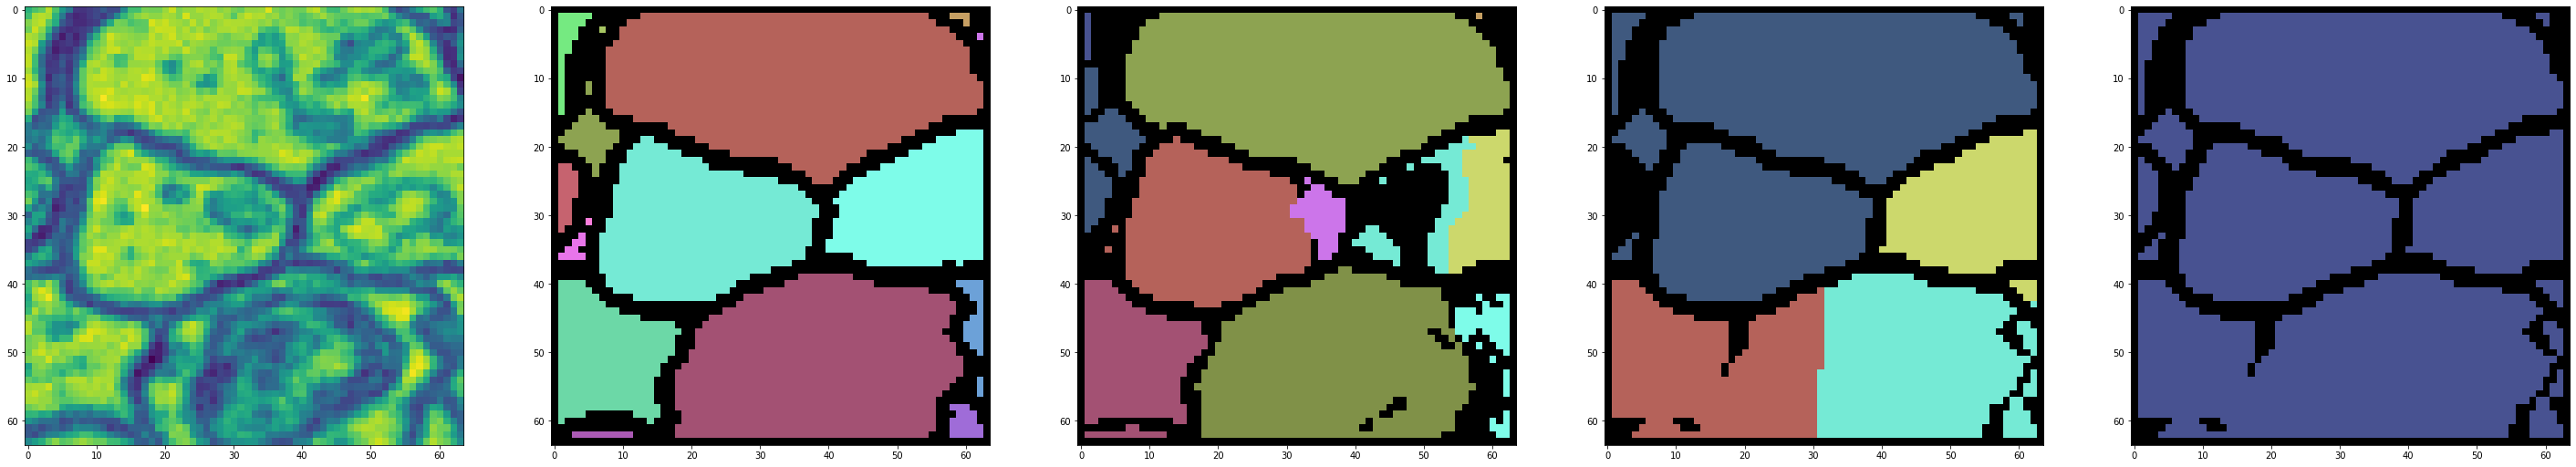

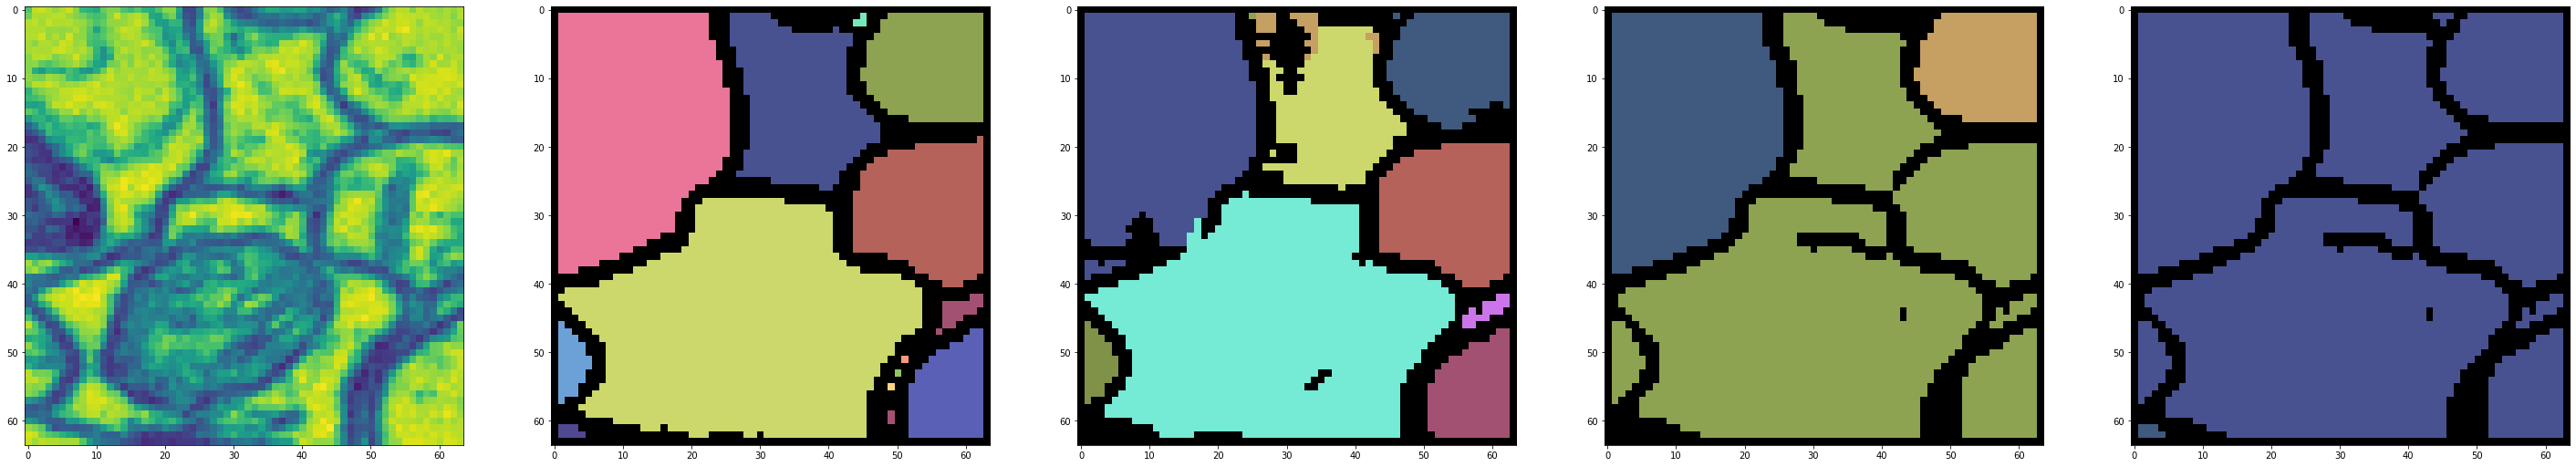

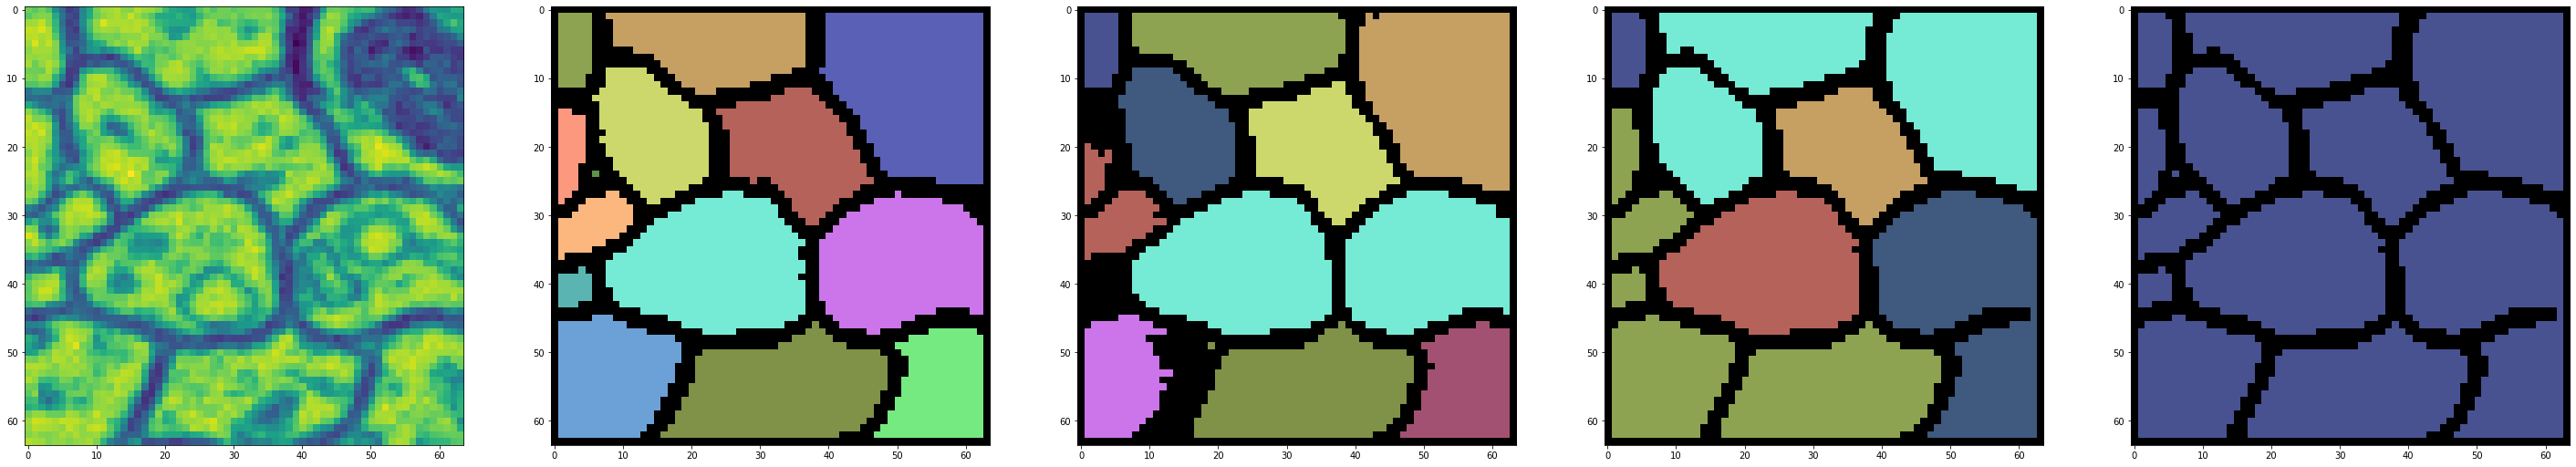

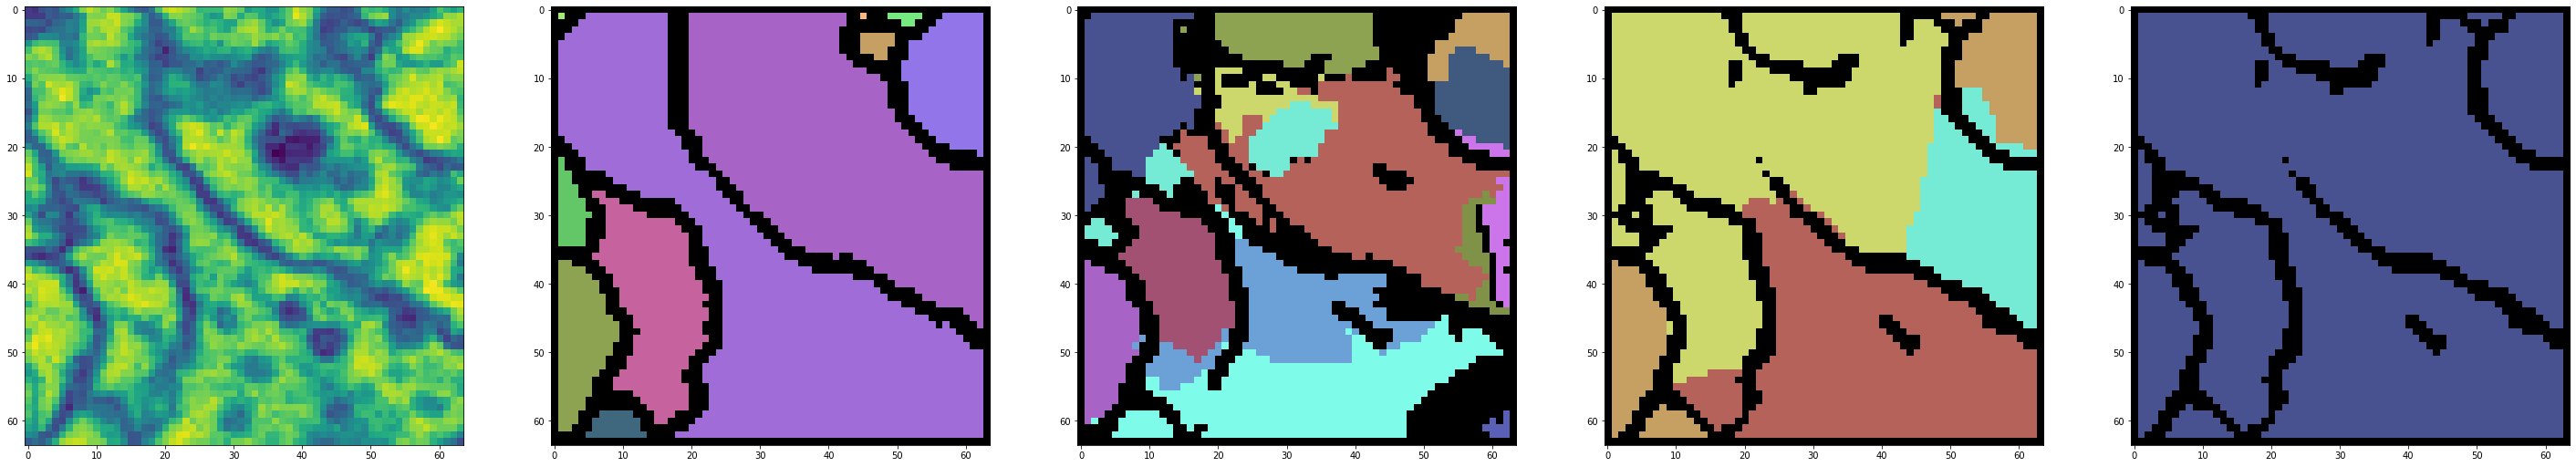

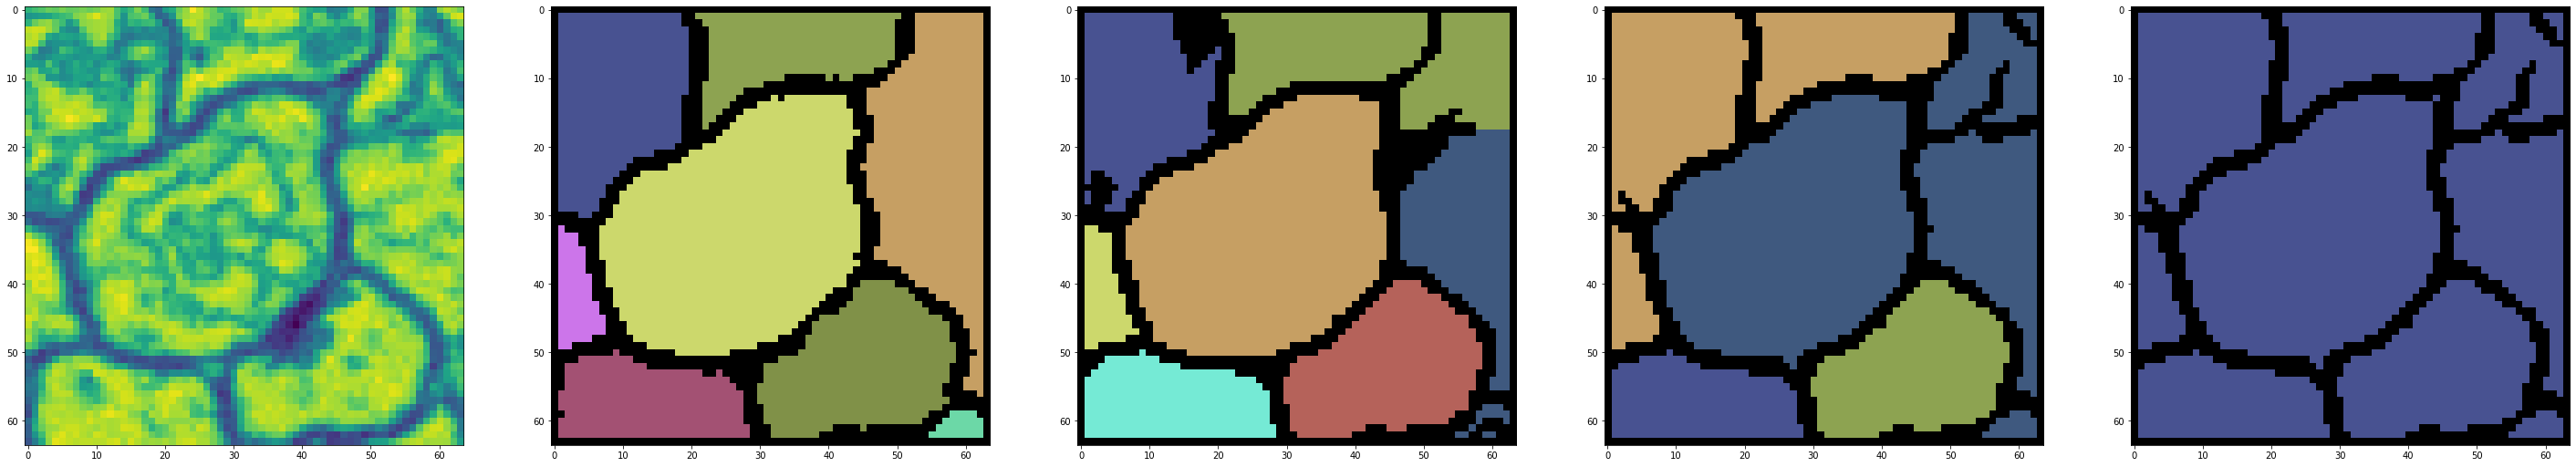

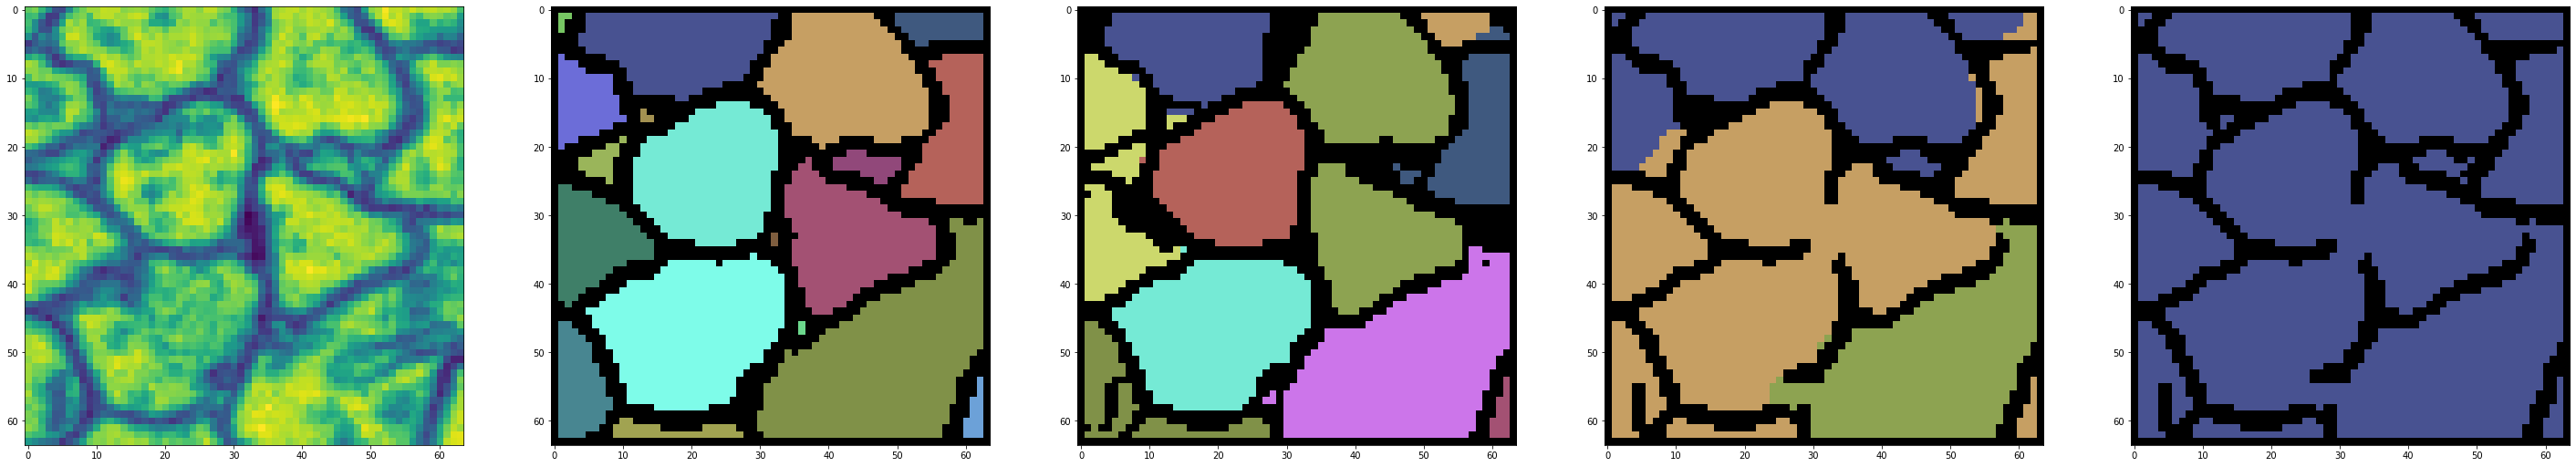

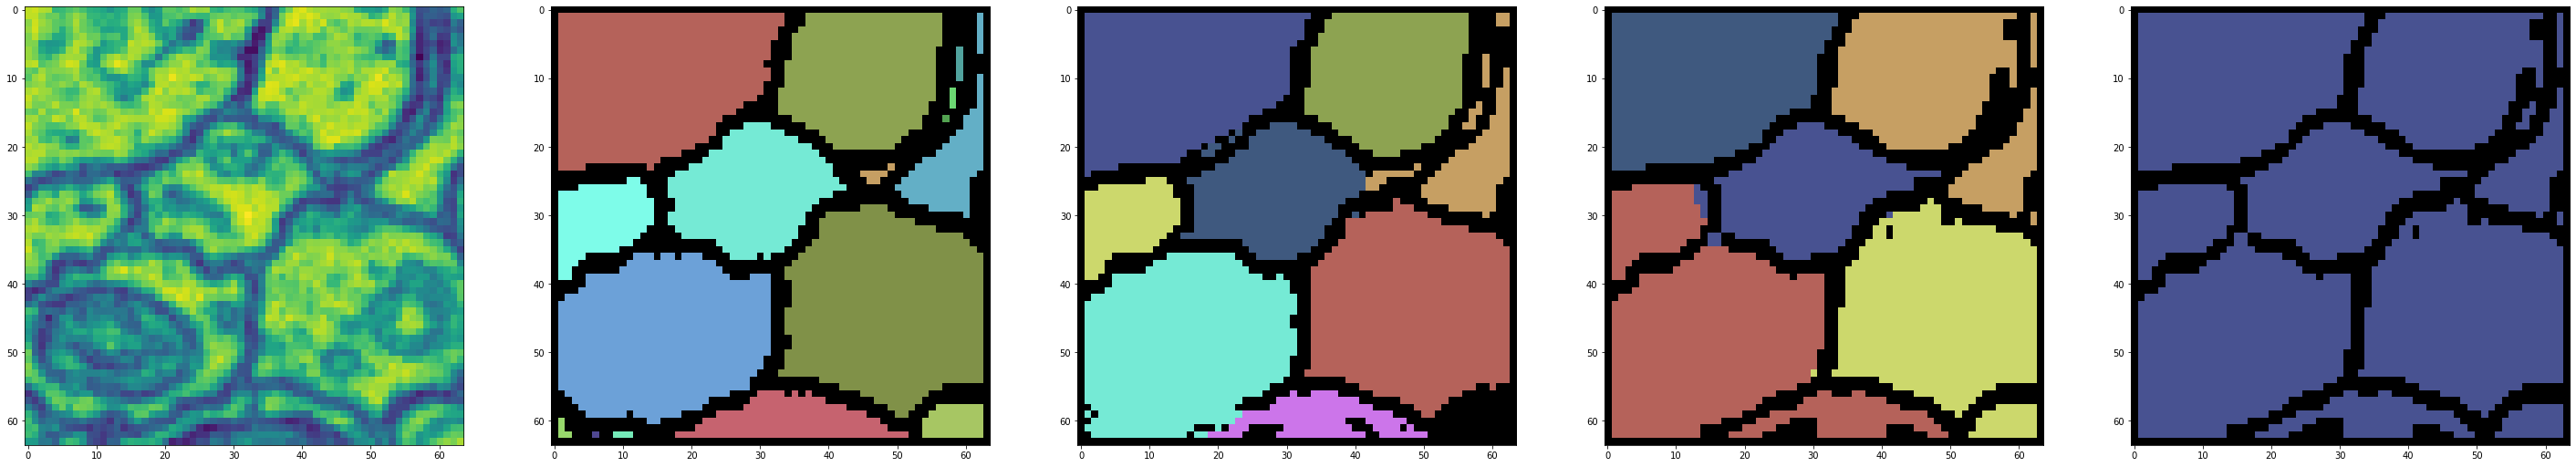

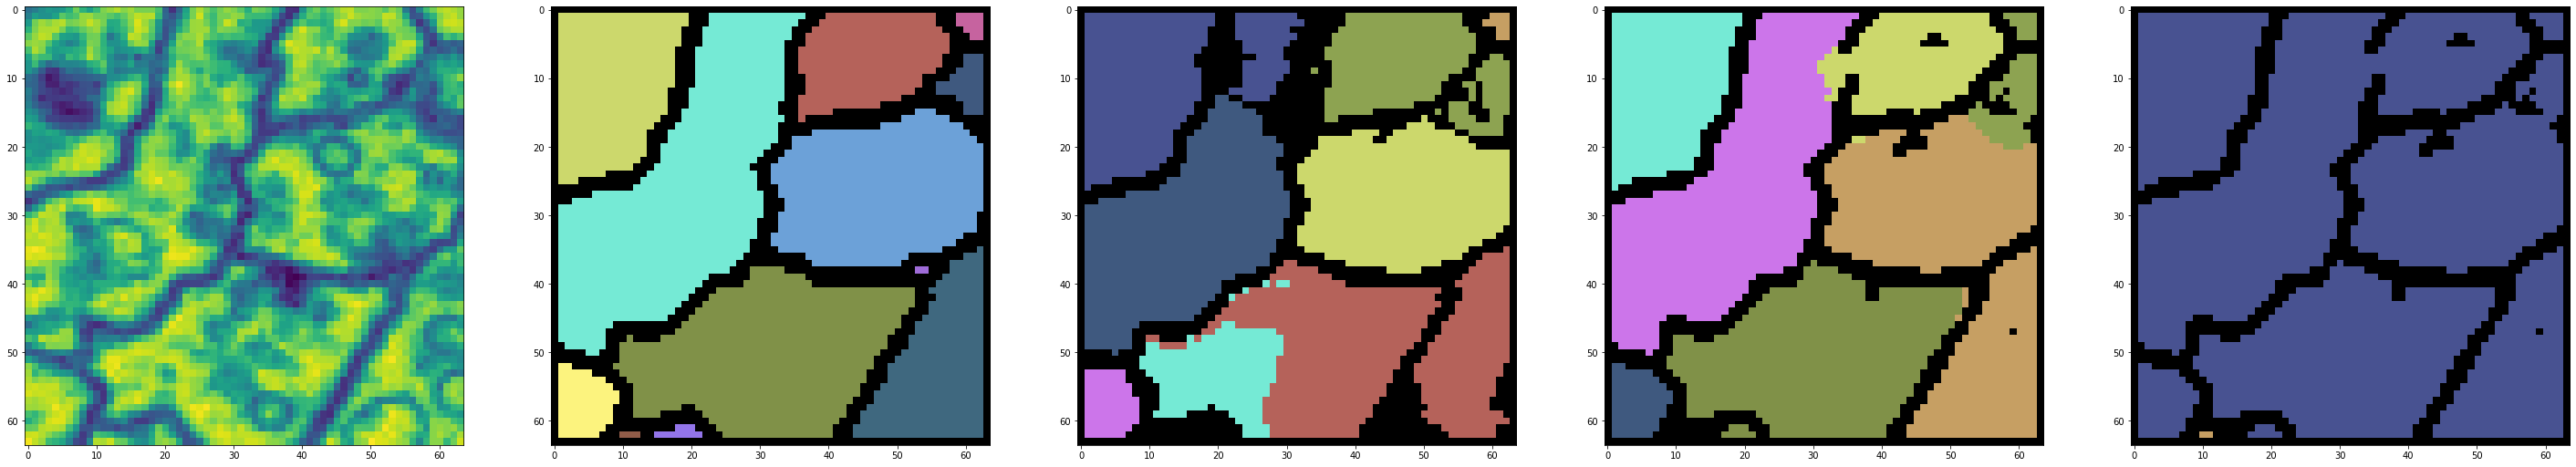

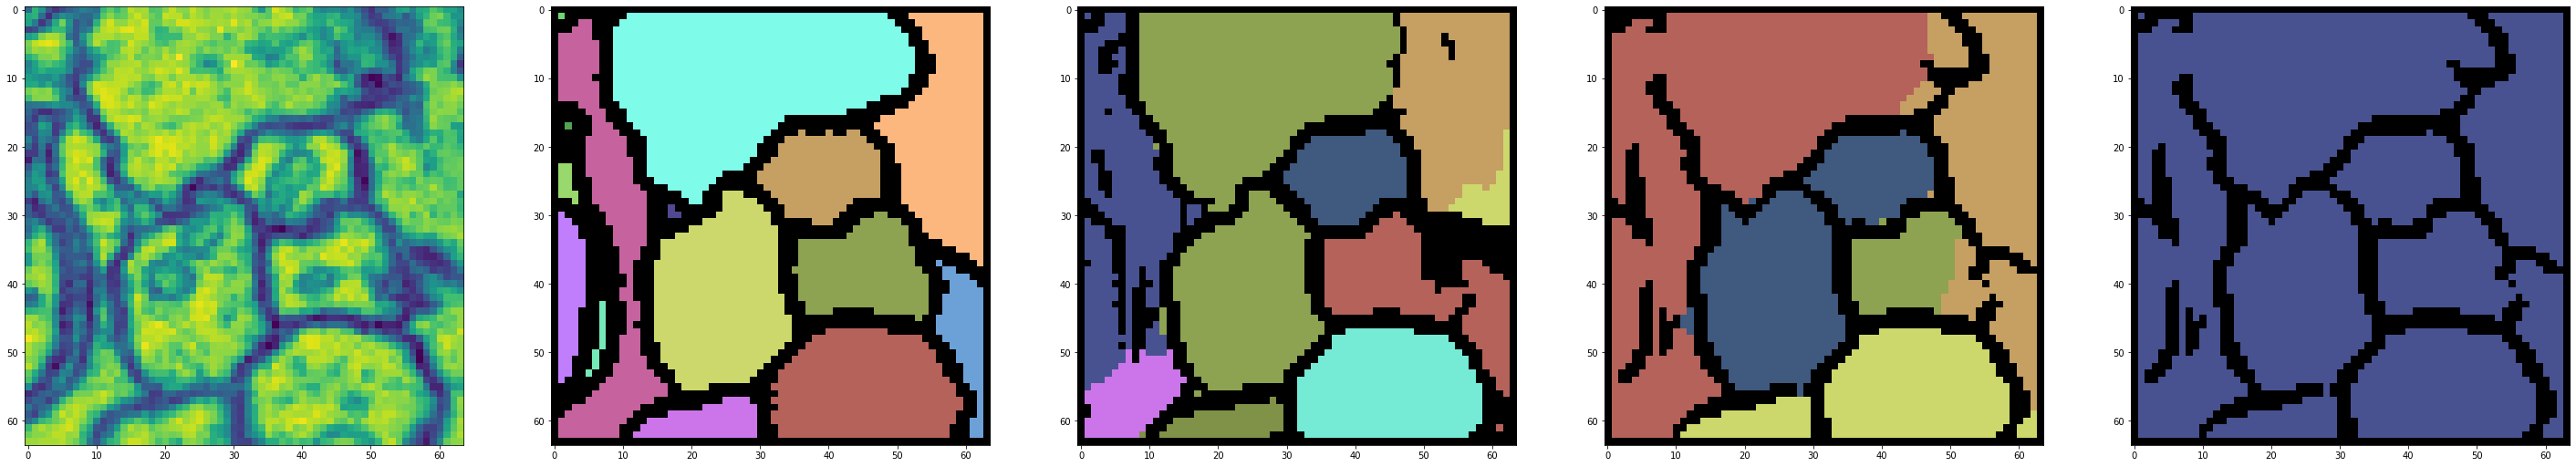

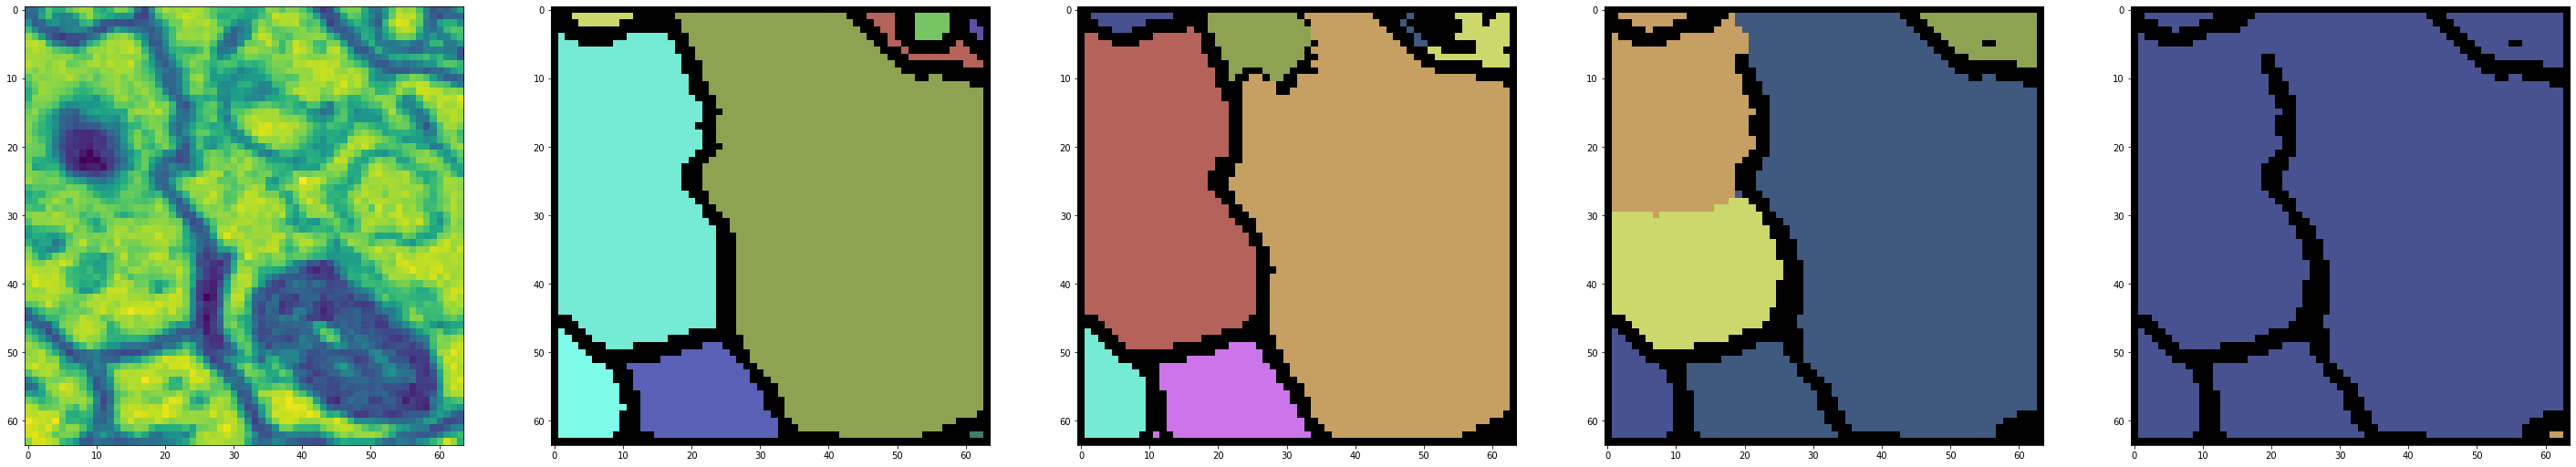

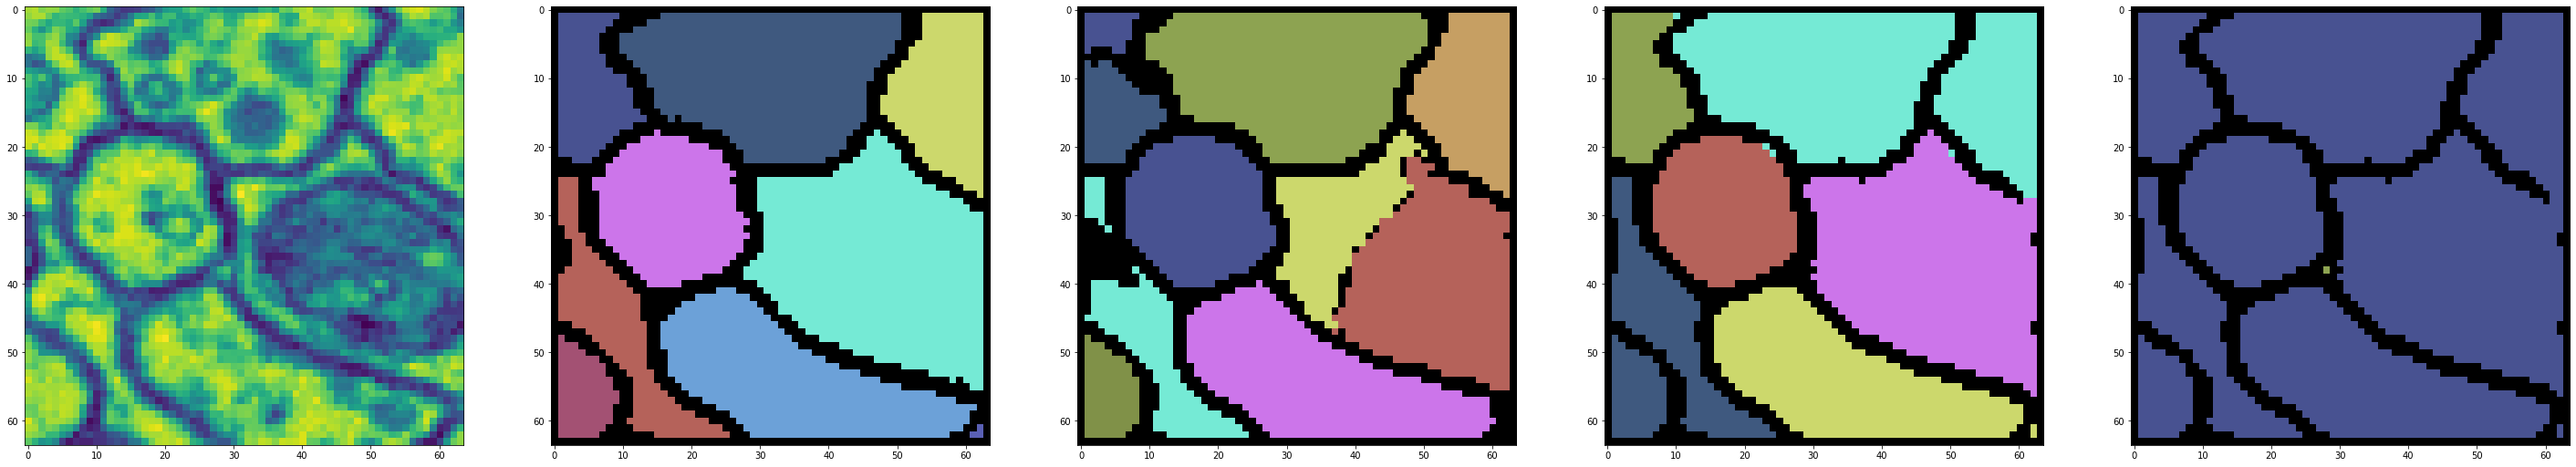

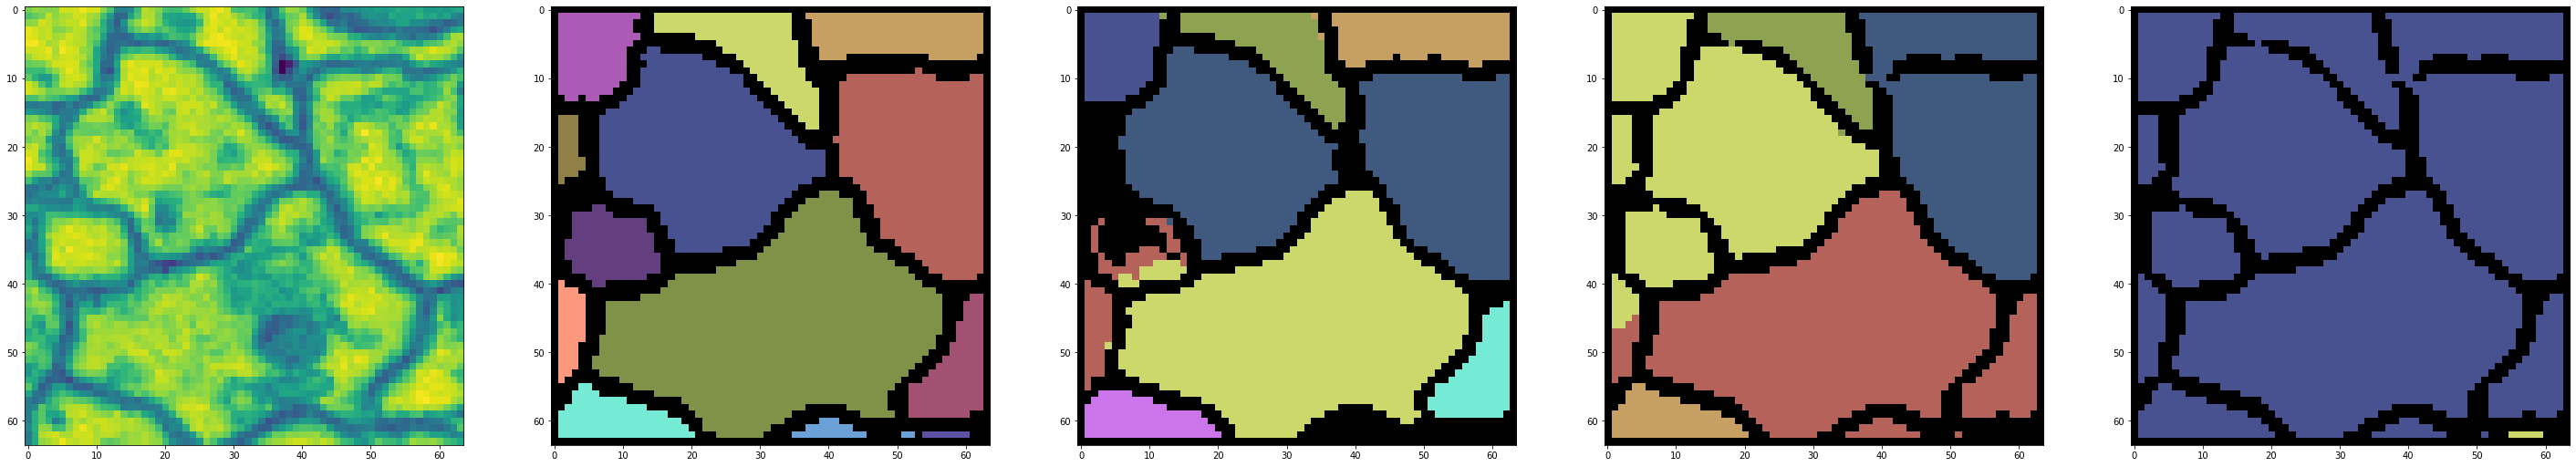

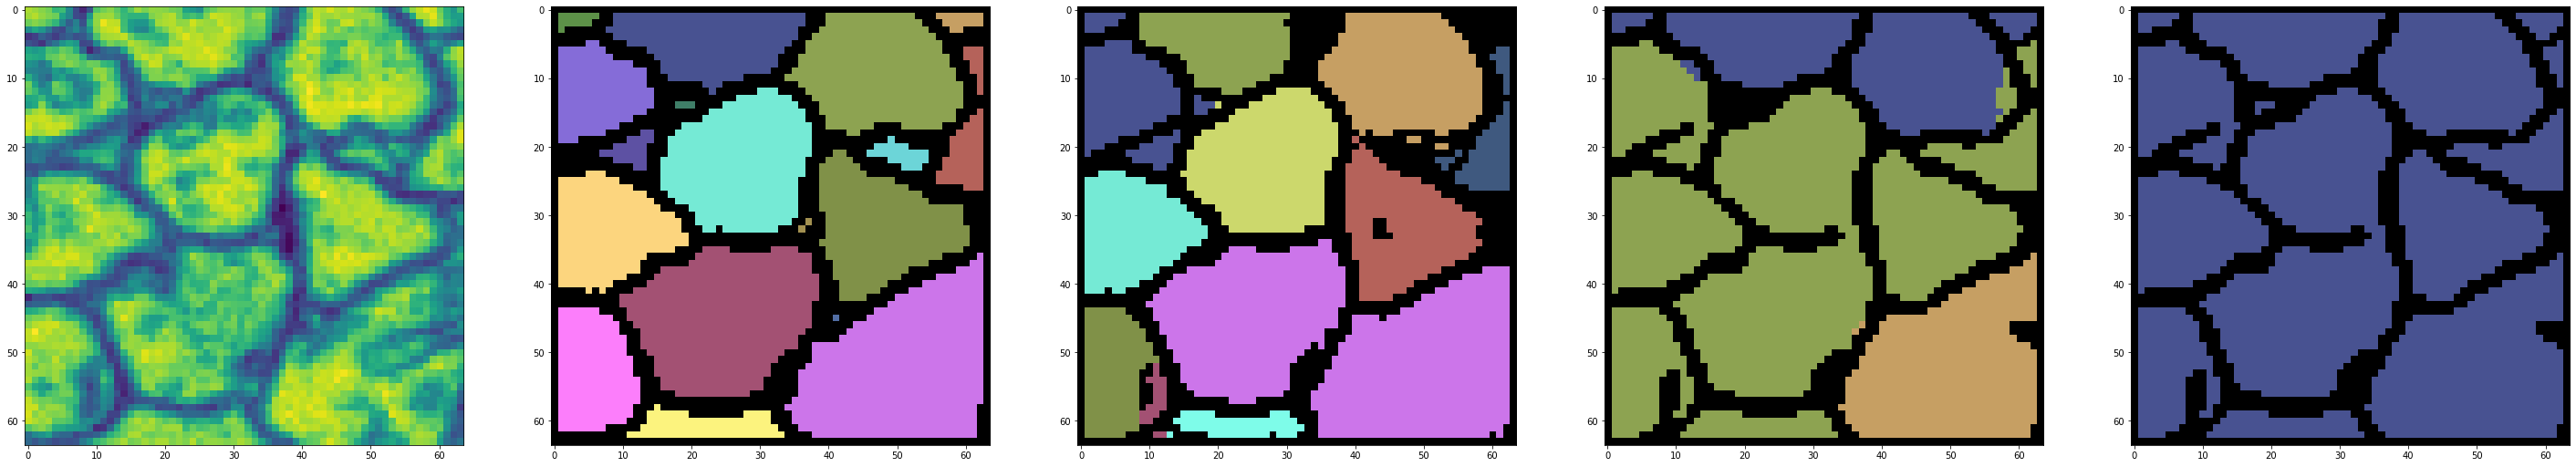

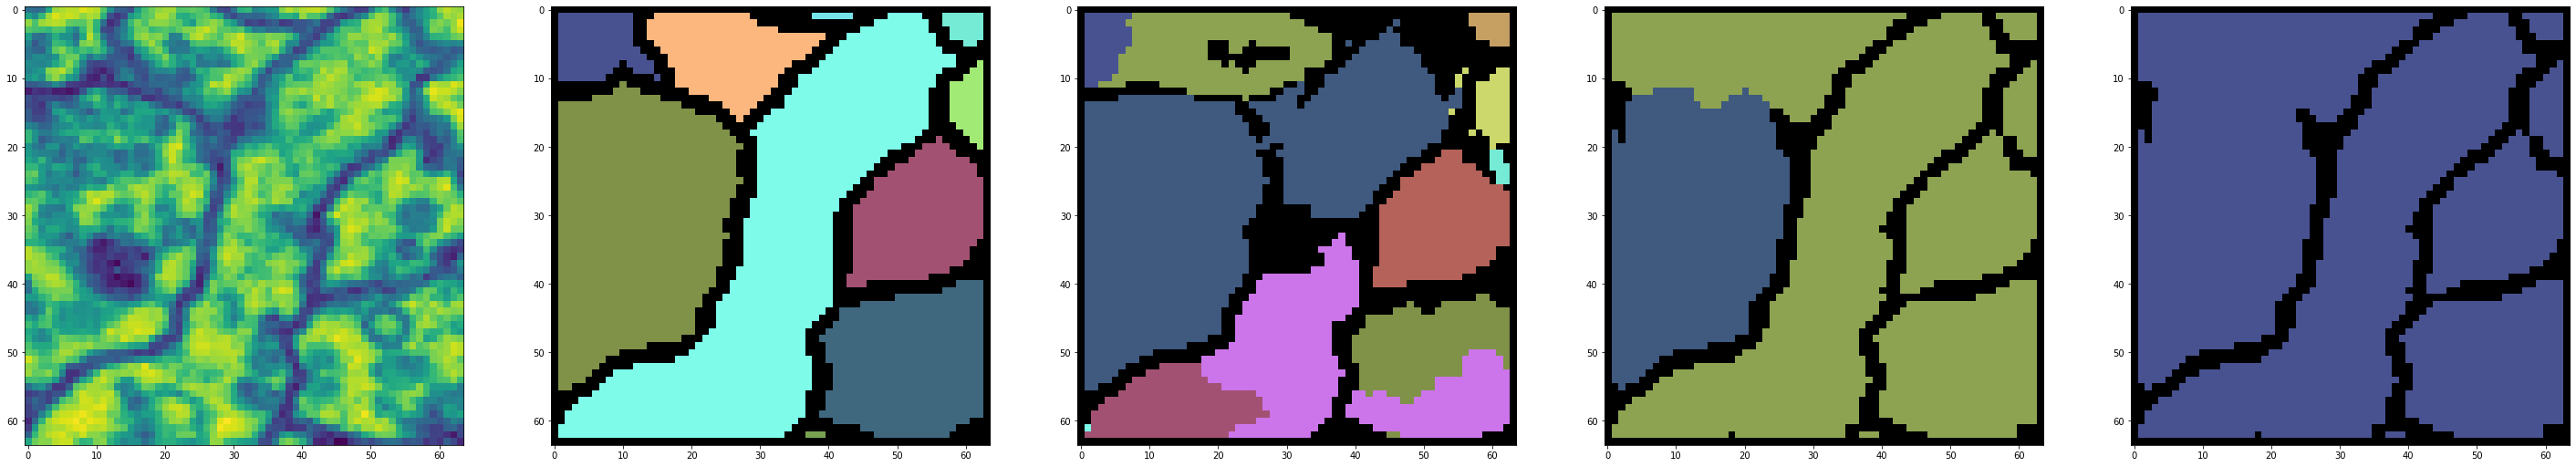

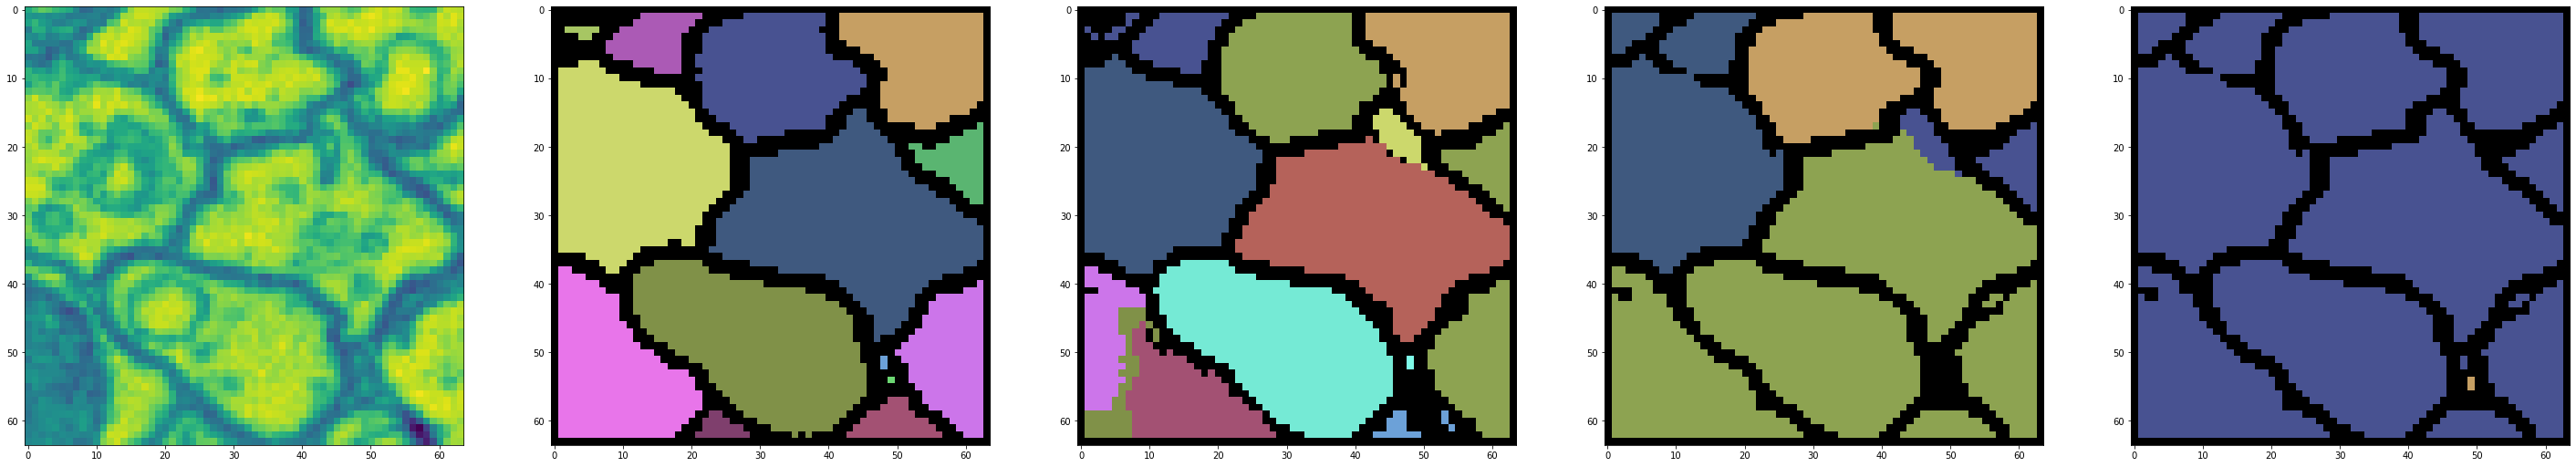

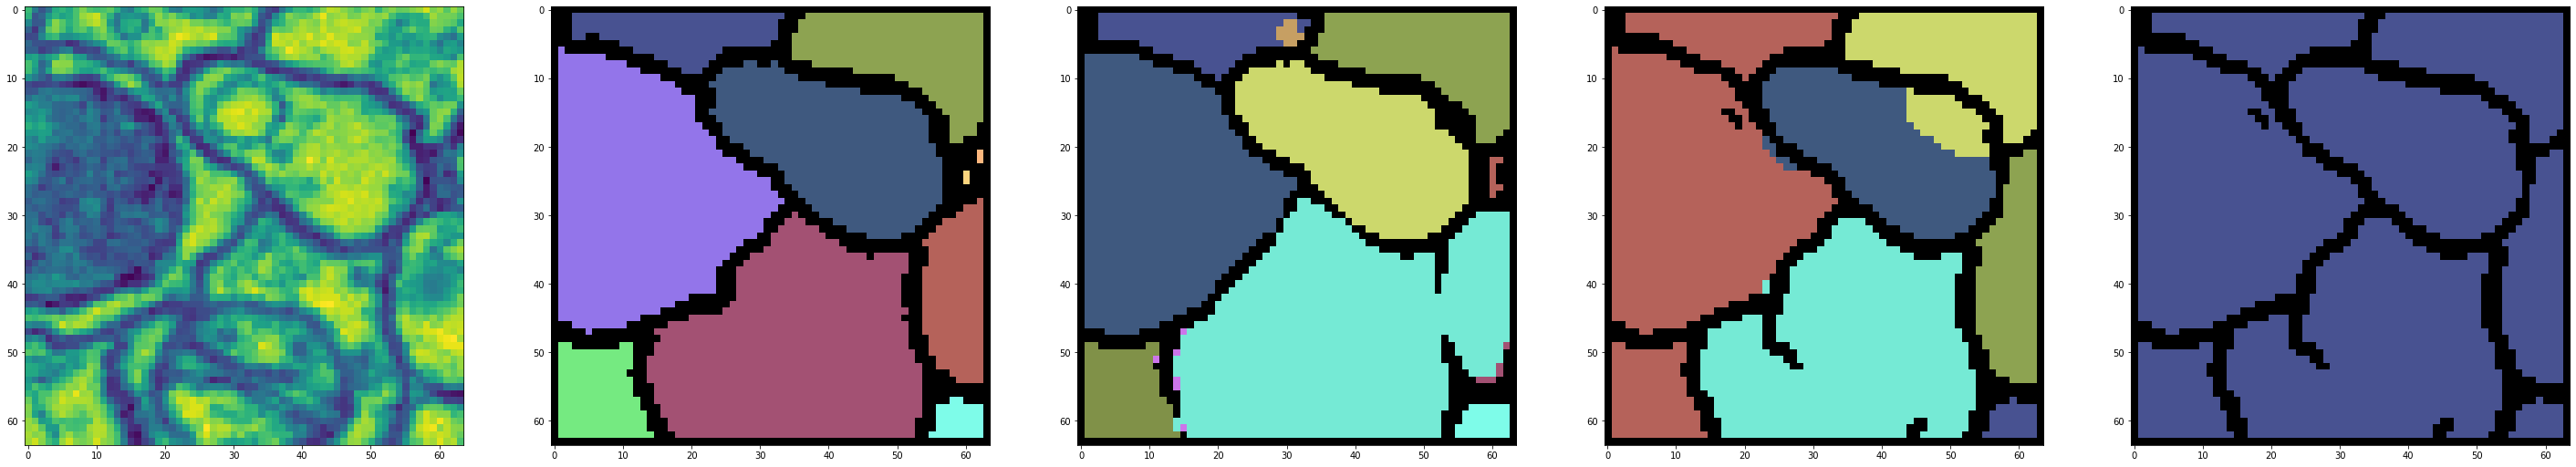

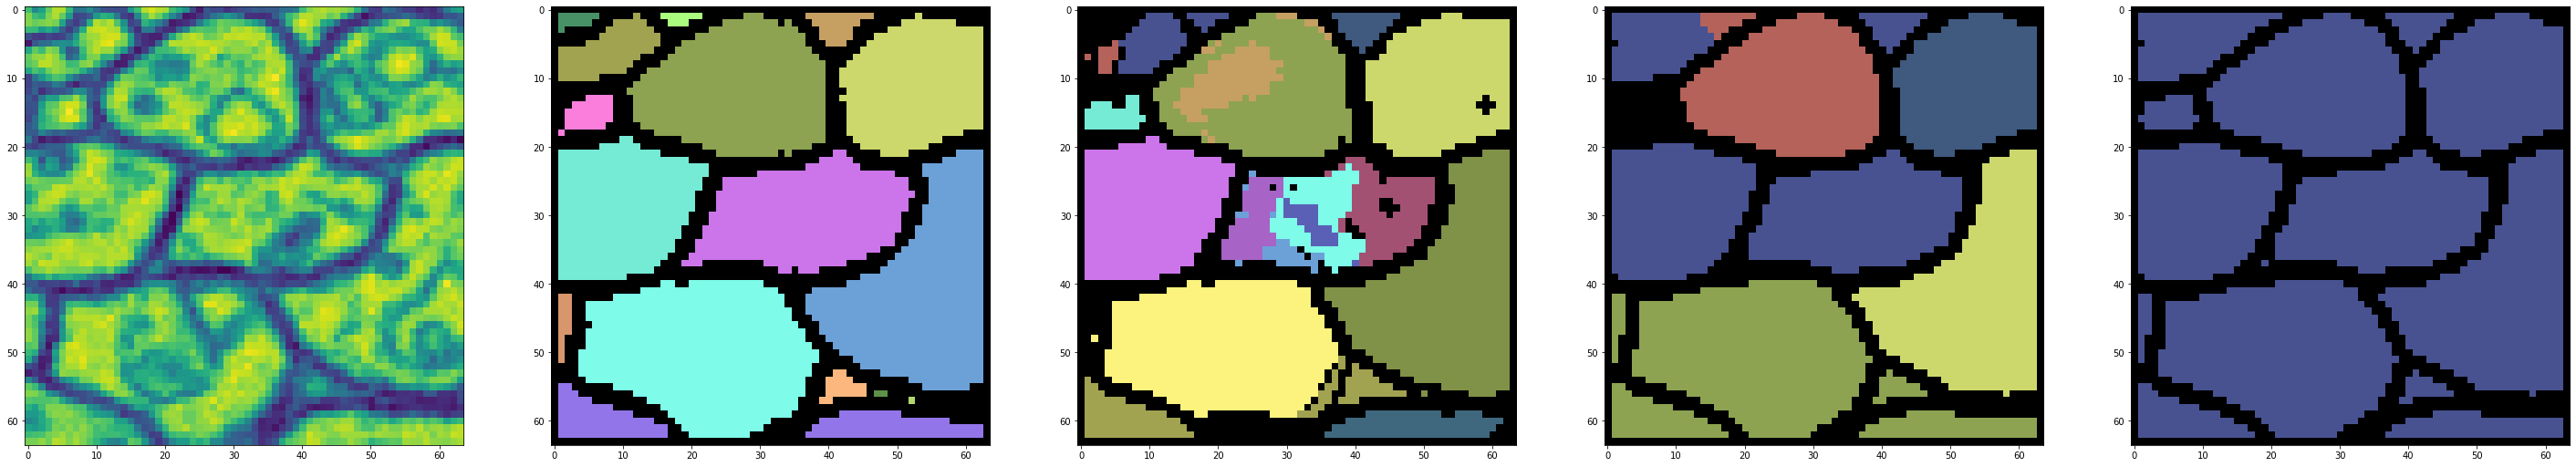

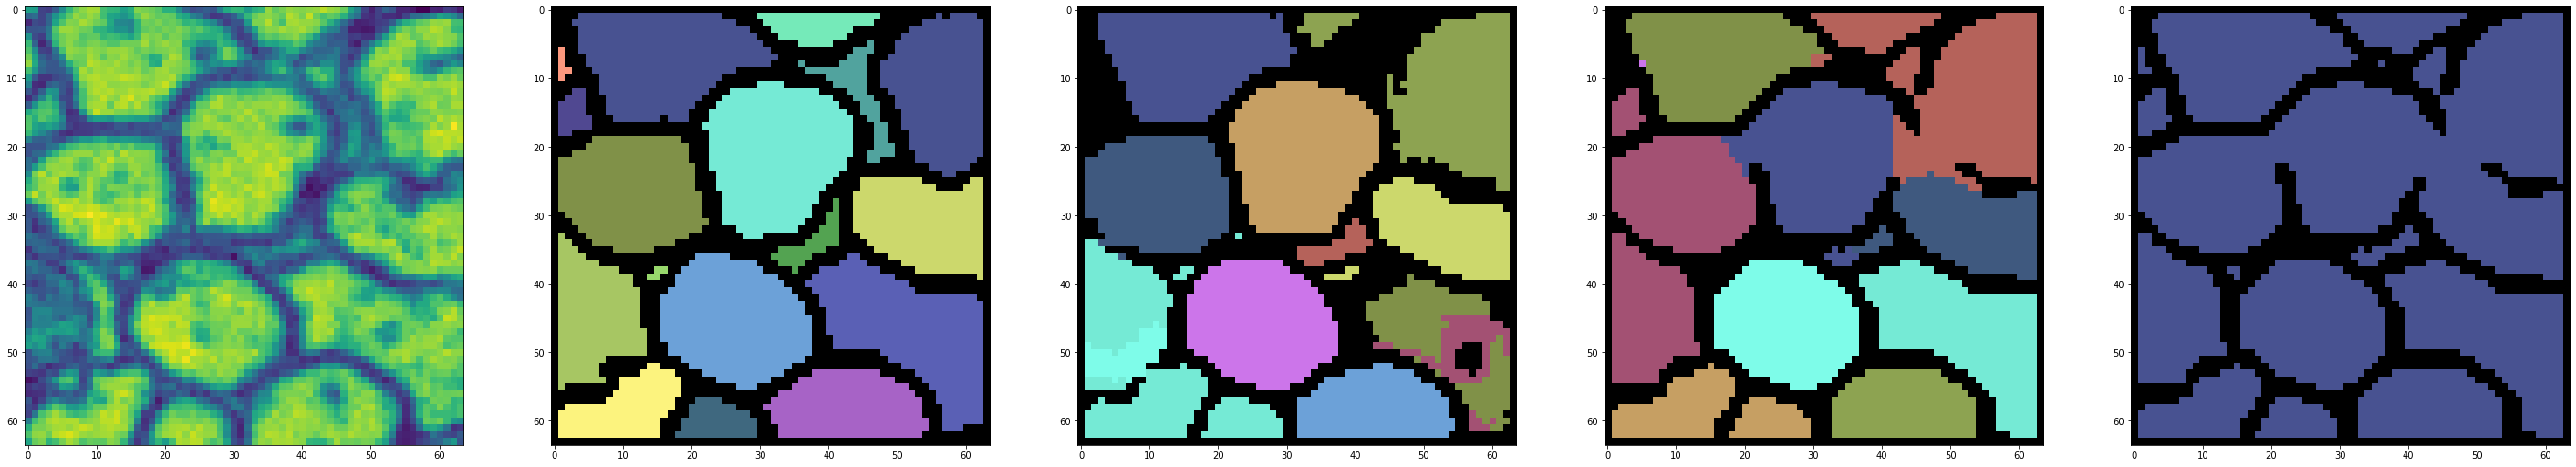

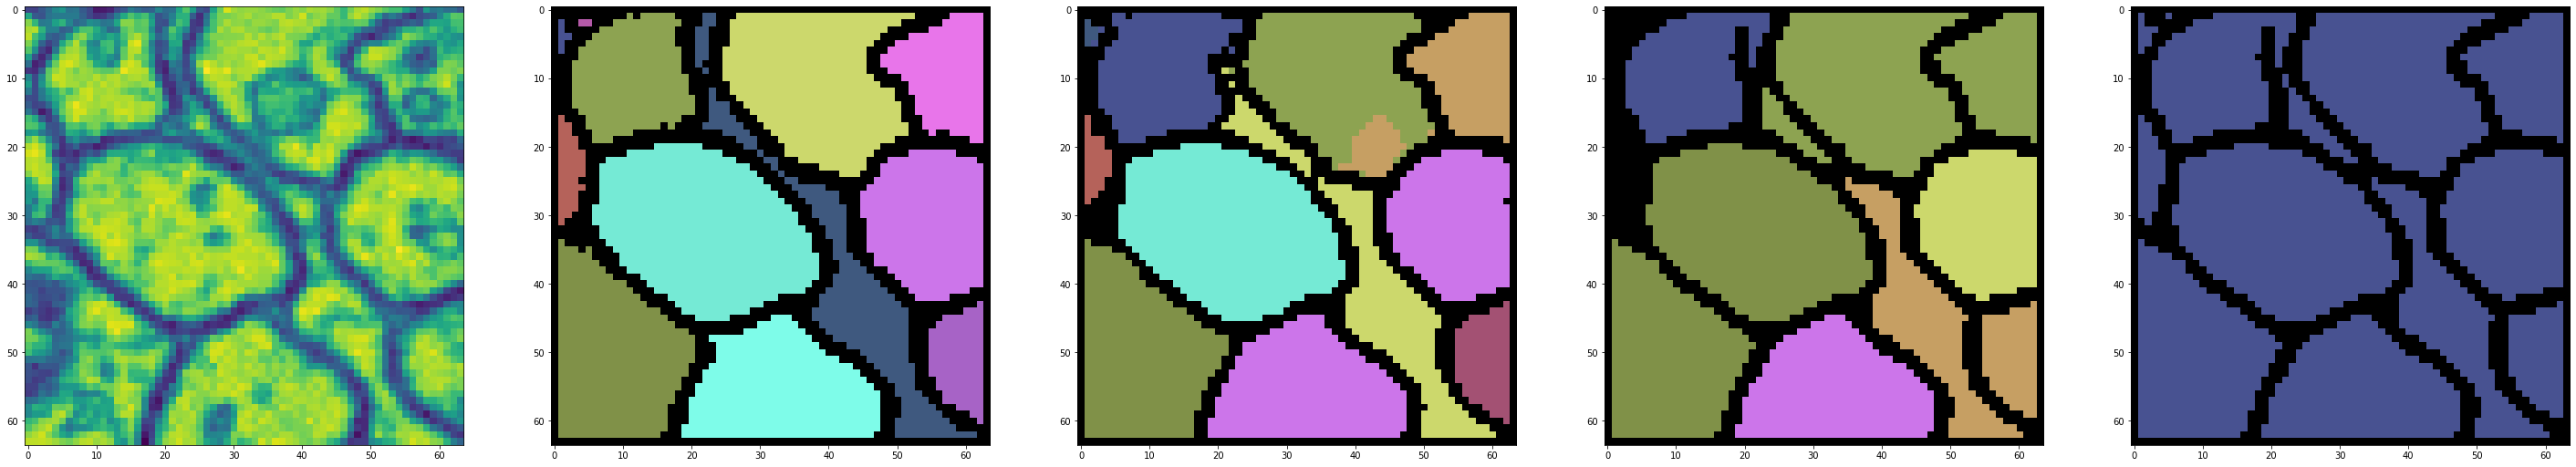

In [62]:
lbl2rgb = color_generator (200)
for idx in range (0, 20):
    fig, ax = plt.subplots (1,5, figsize=(50,15))
    ax [0].imshow (em [idx] [0])
    ax [1].imshow (lbl2rgb (gt [idx][0]))
    ax [2].imshow (lbl2rgb (post_processed [idx][0]))
    ax [3].imshow (lbl2rgb (unet_wsh [idx][0]))
    ax [4].imshow (lbl2rgb (unet_cncpt [idx][0]))
    plt.show ()

In [42]:
result_dir = "3d_cremi_64"
lbl2rgb = color_generator (200)
res = [graphcl, unet_wsh, unet_cncpt, gt, em]
meds = ["graphcl", "wsh", "cncpt"] + ["gt", "em"]
for med, lbl_lists in zip (meds, res):
    med_dir = result_dir + "/" + med + '/'
    os.makedirs (med_dir, exist_ok=True)
    if med in ['em']:
        continue
    
    for i in range (len_test):
        io.imsave (med_dir + '/' + str (i) + '.tif', lbl2rgb (lbl_lists [i]))

        os.makedirs (result_dir + "/" + 'em' + '/', exist_ok=True)
for i in range (len_test):
    io.imsave (result_dir + '/em/' + str (i) + '.tif', em[i])
         

/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//0.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//3.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//4.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/conda/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: 3d_cremi_64/graphcl//5.tif is a low contrast image
  warn('%s is a low